# Visualisation d'arbres du Kingman-coalescent
Ce notebook génère deux réalisations indépendantes d'un arbre Kingman et ajoute des annotations spécifiques (repère du TMRCA, branche terminale prolongée) avant de sauvegarder la figure en SVG/PNG.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [53]:
def simulate_kingman_tree(n, rng):
    """Génère une réalisation complète du Kingman-coalescent pour n lignées."""
    active = [f"leaf_{i}" for i in range(n)]
    events = []
    node_id = 0
    t = 0.0
    while len(active) > 1:
        k = len(active)
        rate = k * (k - 1) / 2
        t += rng.exponential(1.0 / rate)
        children = rng.choice(active, size=2, replace=False)
        parent = f"node_{node_id}"
        node_id += 1
        events.append((parent, list(children), t))
        active = [lin for lin in active if lin not in children]
        active.append(parent)
    root = active[0]
    return events, root


def _build_node_info(events):
    info = {}
    for parent, children, time in events:
        info[parent] = {"children": children, "time": time}
    return info


def compute_positions(events, root, n):
    info = _build_node_info(events)
    positions = {f"leaf_{i}": (float(i), 0.0) for i in range(n)}
    def locate(node):
        if node in positions:
            return positions[node]
        children = info[node]["children"]
        time = info[node]["time"]
        xs = []
        for child in children:
            x_child, _ = locate(child)
            xs.append(x_child)
        x_parent = float(np.mean(xs))
        positions[node] = (x_parent, time)
        return positions[node]
    locate(root)
    return positions, info

In [54]:
def plot_kingman_tree(ax, events, root, n, tau_mean, extension_factor=0.35):
    positions, info = compute_positions(events, root, n)
    root_x, tmrca = positions[root]
    tail_height = max(tmrca * (1.0 + extension_factor), tmrca + 0.5)
    colors = {
        "vertical": "#1f77b4",
        "horizontal": "#d62728",
        "extension": "#1f77b4",  # blue dashed for final branch
    }
    for parent, data in sorted(info.items(), key=lambda item: item[1]["time"]):
        child_xs = []
        px, py = positions[parent]
        for child in data["children"]:
            cx, cy = positions[child]
            child_xs.append(cx)
            ax.plot([cx, cx], [cy, py], color=colors["vertical"], linewidth=1.5)
        ax.plot([min(child_xs), max(child_xs)], [py, py], color=colors["horizontal"], linewidth=2.0)
    ax.plot([root_x, root_x], [tmrca, tail_height], color=colors["extension"], linestyle=(0, (4, 2)), linewidth=2.2)
    ax.axhline(tmrca, color="#666666", linestyle="--", linewidth=1.1)
    ax.axhline(tau_mean, color="#1f77b4", linestyle="--", linewidth=1.1)
    # y-ticks: only 0, 1, TMRCA, tau_mean (no 1.99 or 0.5 etc.)
    y_ticks = np.array([0.0, 1.0, tmrca, tau_mean])
    # Remove near-duplicates and sort
    y_ticks = np.unique(np.round(y_ticks, 10))
    y_ticks.sort()
    y_labels = []
    for tick in y_ticks:
        if np.isclose(tick, tmrca):
            y_labels.append("TMRCA")
        elif np.isclose(tick, tau_mean):
            y_labels.append(r"$\tau_{\delta_0,n}$")
        else:
            y_labels.append(f"{tick:.0f}")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    # Top ticks for individuals, every position, outward; labels for 1, mid, n
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(0, n))
    top_labels = [""] * n
    mid = (n + 1) // 2
    top_labels[0] = "1"
    top_labels[mid - 1] = f"{mid}"
    top_labels[n - 1] = f"{n}"
    ax.set_xticklabels(top_labels)
    ax.tick_params(axis="x", direction="out", length=4)
    ax.set_xlabel("")
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(0, tail_height)
    ax.invert_yaxis()
    ax.set_title("Réalisation d'un arbre de Kingman issue de n=20 lignées.")
    ax.grid(alpha=0.2, axis="y")
    return tmrca, tail_height, root_x


def lineage_step_data(events, n, tail_height):
    sorted_events = sorted(events, key=lambda evt: evt[2])
    times = [0.0]
    counts = [n]
    current = n
    for _, _, t in sorted_events:
        times.append(t)
        counts.append(current)
        current -= 1
        times.append(t)
        counts.append(current)
    times.append(tail_height)
    counts.append(current)
    return np.array(counts), np.array(times)


def plot_lineage_panel(ax, counts, times, tmrca, tau_mean, n, tail_height):
    ax.plot(counts, times, color="#1f78b4", linewidth=2.0)
    ax.axhline(tmrca, color="#666666", linestyle="--", linewidth=1.1)
    ax.axhline(tau_mean, color="#1f77b4", linestyle="--", linewidth=1.1)
    ax.set_xlim(0.5, n + 0.5)
    ax.set_xticks([1, n])
    ax.set_xticklabels(["1", f"{n}"])
    ax.set_xlabel("Nombre de lignées")
    ax.set_ylim(0, tail_height)
    ax.invert_yaxis()
    ax.set_ylabel("")
    # ax.set_title("Lignées restantes")
    ax.grid(alpha=0.2, axis="y")

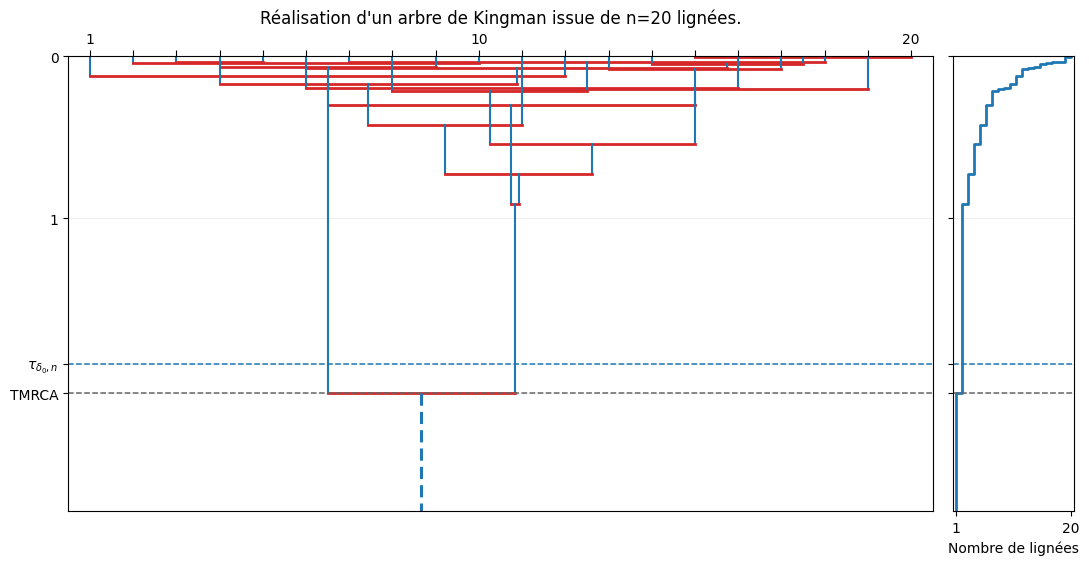

(WindowsPath('LaTeX/photo/plot_arbre_kingman.svg'),
 WindowsPath('LaTeX/photo/plot_arbre_kingman.png'))

In [55]:
rng = np.random.default_rng(1)
n = 20
# Force the displayed mean at the known value 1.9 for n=20
tau_mean = 2.0 * (1.0 - 1.0 / n)
assert np.isclose(tau_mean, 1.9)
events, root = simulate_kingman_tree(n, rng)
fig, (tree_ax, lineage_ax) = plt.subplots(
    1,
    2,
    figsize=(11, 6),
    sharey=True,
    gridspec_kw={"width_ratios": [5, 0.7]},
)
tmrca, tail_height, root_x = plot_kingman_tree(tree_ax, events, root, n, tau_mean)
counts, times = lineage_step_data(events, n, tail_height)
plot_lineage_panel(lineage_ax, counts, times, tmrca, tau_mean, n, tail_height)
# fig.suptitle(f"Kingman-coalescent (n={n})", fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.96))
output_dir = Path("LaTeX/photo")
output_dir.mkdir(parents=True, exist_ok=True)
svg_path = output_dir / "plot_arbre_kingman.svg"
png_path = output_dir / "plot_arbre_kingman.png"
fig.savefig(svg_path)
fig.savefig(png_path, dpi=300)
plt.show()
svg_path, png_path